In [1]:
from signalalign.hiddenMarkovModel import HmmModel
from signalalign.visualization.plot_em_model_distributions import get_covered_bases
from scipy.stats import norm, invgauss, entropy
from scipy.spatial.distance import euclidean
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
native = "/Users/andrewbailey/CLionProjects/personal/projects/ares_rRNA/sa_training/supervised/more_data_ivt_native/mod_only_local_variant_calling/ivt_native_all/per_position/per_position_data_0.5.csv"
native_acc_df = pd.read_csv(native)
knockdown = "/Users/andrewbailey/CLionProjects/personal/projects/ares_rRNA/sa_training/supervised/more_data_ivt_native/mod_only_local_variant_calling/depletions_all/per_position/per_position_data_0.5.csv"
knockdown_acc_df = pd.read_csv(knockdown)
def read_in_mod_data():
    mods = "/Users/andrewbailey/CLionProjects/personal/projects/ares_rRNA/mod_files/misc/mod_file.csv"
    mods_df = pd.read_csv(mods)
    mods_df["reference_index"] = mods_df["pos"] - 1
    return mods_df
mods_df = read_in_mod_data()

In [3]:
knockdown_acc_df['delta1'] = knockdown_acc_df.reference_index.diff().shift(-1)
knockdown_acc_df['delta2'] = knockdown_acc_df.reference_index.diff().shift(0)
knockdown_acc_df['delta'] = knockdown_acc_df[["delta1", "delta2"]].min(axis=1)

native_acc_df['delta1'] = knockdown_acc_df.reference_index.diff().shift(-1)
native_acc_df['delta2'] = knockdown_acc_df.reference_index.diff().shift(0)
native_acc_df['delta'] = knockdown_acc_df[["delta1", "delta2"]].min(axis=1)

knockdown_acc_df["in_2prime"] = (((knockdown_acc_df.variants.shift().isin(["Aa", "Cb", "Gc", "Td", "Tdm"]) & 
                                  (knockdown_acc_df.delta2 <= 5)) | 
                                 (knockdown_acc_df.variants.shift(-1).isin(["Aa", "Cb", "Gc", "Td", "Tdm"]) & 
                                  (knockdown_acc_df.delta1 <= 5))) & (~knockdown_acc_df.variants.isin(["Aa", "Cb", "Gc", "Td"])))  
knockdown_acc_df["in_pseudo"] = (((knockdown_acc_df.variants.shift().isin(["Tl"]) & 
                                   (knockdown_acc_df.delta2 <= 5)) | 
                                  (knockdown_acc_df.variants.shift(-1).isin(["Tl", "Tdm"]) & 
                                   (knockdown_acc_df.delta1 <= 5))) & 
                                 (~knockdown_acc_df.variants.isin(["Tl"]))) 
knockdown_acc_df["in_unknown"] = (knockdown_acc_df["in_pseudo"] | knockdown_acc_df["in_2prime"])
native_acc_df["in_2prime"] = knockdown_acc_df["in_2prime"]
native_acc_df["in_pseudo"] = knockdown_acc_df["in_pseudo"]
native_acc_df["in_unknown"] = knockdown_acc_df["in_unknown"]

In [4]:
knockdown_acc_df

,contig,reference_index,strand,variants,accuracy,precision,negative_predictive_value,recall,specificity,positive_likelihood_ratio,...,prevalence,aucroc,avg_precision,brier_score,delta1,delta2,delta,in_2prime,in_pseudo,in_unknown
0,RDN18-1,27,+,Aa,0.6079,0.6042,0.6178,0.8118,0.3639,1.2762,...,0.5447,0.5831,0.5837,0.3462,72.0,NaN,72.0,False,False,False
1,RDN18-1,99,+,Aa,0.6497,0.6511,0.6461,0.8316,0.4083,1.4053,...,0.5704,0.6105,0.6259,0.2950,6.0,72.0,6.0,False,False,False
2,RDN18-1,105,+,Tl,0.6815,0.5897,0.8270,0.8438,0.5599,1.9172,...,0.4285,0.7696,0.6622,0.2627,14.0,6.0,6.0,False,False,False
3,RDN18-1,119,+,Tl,0.5751,0.5021,0.7688,0.8521,0.3679,1.3480,...,0.4279,0.6561,0.5387,0.3150,91.0,14.0,14.0,False,False,False
4,RDN18-1,210,+,Tl,0.5147,0.4665,0.8059,0.9356,0.2000,1.1695,...,0.4278,0.6920,0.5815,0.4171,91.0,91.0,91.0,False,False,False
5,RDN18-1,301,+,Tl,0.6284,0.5467,0.7724,0.8091,0.4914,1.5908,...,0.4312,0.6899,0.5703,0.2959,112.0,91.0,91.0,False,False,False
6,RDN18-1,413,+,Cb,0.6169,0.6072,0.6684,0.9070,0.2421,1.1968,...,0.5636,0.5667,0.5975,0.3553,6.0,112.0,6.0,False,False,False
7,RDN18-1,419,+,Aa,0.5466,0.5834,0.4749,0.6836,0.3695,1.0843,...,0.5636,0.5243,0.5683,0.3213,16.0,6.0,6.0,False,False,False
8,RDN18-1,435,+,Aa,0.6470,0.6221,0.8000,0.9503,0.2564,1.2778,...,0.5630,0.6549,0.6566,0.3229,30.0,16.0,16.0,False,False,False
9,RDN18-1,465,+,Tl,0.5673,0.5031,0.6629,0.6894,0.4728,1.3078,...,0.4363,0.6044,0.5157,0.3873,75.0,30.0,30.0,False,False,False


In [5]:
mod_data = mods_df[["contig", "reference_index", "percent"]]
knockdown_acc_df = pd.merge(knockdown_acc_df, mod_data, on=["contig", "reference_index"])
native_acc_df = pd.merge(native_acc_df, mod_data, on=["contig", "reference_index"])


In [6]:
knockdown_acc_df.head()

,contig,reference_index,strand,variants,accuracy,precision,negative_predictive_value,recall,specificity,positive_likelihood_ratio,...,aucroc,avg_precision,brier_score,delta1,delta2,delta,in_2prime,in_pseudo,in_unknown,percent
0,RDN18-1,27,+,Aa,0.6079,0.6042,0.6178,0.8118,0.3639,1.2762,...,0.5831,0.5837,0.3462,72.0,NaN,72.0,False,False,False,95
1,RDN18-1,99,+,Aa,0.6497,0.6511,0.6461,0.8316,0.4083,1.4053,...,0.6105,0.6259,0.2950,6.0,72.0,6.0,False,False,False,80
2,RDN18-1,105,+,Tl,0.6815,0.5897,0.8270,0.8438,0.5599,1.9172,...,0.7696,0.6622,0.2627,14.0,6.0,6.0,False,False,False,95
3,RDN18-1,119,+,Tl,0.5751,0.5021,0.7688,0.8521,0.3679,1.3480,...,0.6561,0.5387,0.3150,91.0,14.0,14.0,False,False,False,95
4,RDN18-1,210,+,Tl,0.5147,0.4665,0.8059,0.9356,0.2000,1.1695,...,0.6920,0.5815,0.4171,91.0,91.0,91.0,False,False,False,83


In [7]:
native_acc_df.head()

,contig,reference_index,strand,variants,accuracy,precision,negative_predictive_value,recall,specificity,positive_likelihood_ratio,...,aucroc,avg_precision,brier_score,delta1,delta2,delta,in_2prime,in_pseudo,in_unknown,percent
0,RDN18-1,27,+,Aa,0.9082,0.9770,0.8538,0.8408,0.9792,40.4074,...,0.9675,0.9672,0.0752,72.0,NaN,72.0,False,False,False,95
1,RDN18-1,99,+,Aa,0.8764,0.9196,0.8338,0.8451,0.9131,9.7278,...,0.9299,0.9371,0.1002,6.0,72.0,6.0,False,False,False,80
2,RDN18-1,105,+,Tl,0.8718,0.8557,0.8940,0.9171,0.8187,5.0591,...,0.9371,0.9382,0.1012,14.0,6.0,6.0,False,False,False,95
3,RDN18-1,119,+,Tl,0.7200,0.7046,0.7465,0.8267,0.5956,2.0441,...,0.7670,0.7362,0.2052,91.0,14.0,14.0,False,False,False,95
4,RDN18-1,210,+,Tl,0.7140,0.6768,0.8140,0.9073,0.4837,1.7571,...,0.8479,0.8646,0.2188,91.0,91.0,91.0,False,False,False,83


In [8]:
knockdown_no_pm = knockdown_acc_df.loc[~knockdown_acc_df['variants'].isin(["Aa", "Tl", "Cb", "Gc", "Td"])]
native_no_pm = native_acc_df.loc[~knockdown_acc_df['variants'].isin(["Aa", "Tl", "Cb", "Gc", "Td"])]
knockdown_pm = knockdown_acc_df.loc[knockdown_acc_df['variants'].isin(["Aa", "Tl", "Cb", "Gc", "Td"])]
native_pm = native_acc_df.loc[knockdown_acc_df['variants'].isin(["Aa", "Tl", "Cb", "Gc", "Td"])]


In [9]:
native_no_pm.head()
knockdown_no_pm.head()
# pd.set_option("display.max_rows", None, "display.max_columns", None)

# print(native_acc_df[["contig", "reference_index", "variants", "recall", "in_unknown"]])

,contig,reference_index,strand,variants,accuracy,precision,negative_predictive_value,recall,specificity,positive_likelihood_ratio,...,aucroc,avg_precision,brier_score,delta1,delta2,delta,in_2prime,in_pseudo,in_unknown,percent
24,RDN18-1,1190,+,Tg,0.7618,1.0,0.0,0.7618,NaN,NaN,...,NaN,1.0,0.6752,78.0,4.0,4.0,False,True,True,100
27,RDN18-1,1279,+,Ci,0.5471,1.0,0.0,0.5471,NaN,NaN,...,NaN,1.0,0.5151,10.0,9.0,9.0,False,False,False,84
32,RDN18-1,1574,+,Gk,0.9718,1.0,0.0,0.9718,NaN,NaN,...,NaN,1.0,0.9523,64.0,3.0,3.0,True,False,True,95
34,RDN18-1,1772,+,Ci,0.8387,1.0,0.0,0.8387,NaN,NaN,...,NaN,1.0,0.7604,8.0,134.0,8.0,False,False,False,95
35,RDN18-1,1780,+,Aj,0.8931,1.0,0.0,0.8931,NaN,NaN,...,NaN,1.0,0.8114,1.0,8.0,1.0,False,False,False,90


<IPython.core.display.Javascript object>


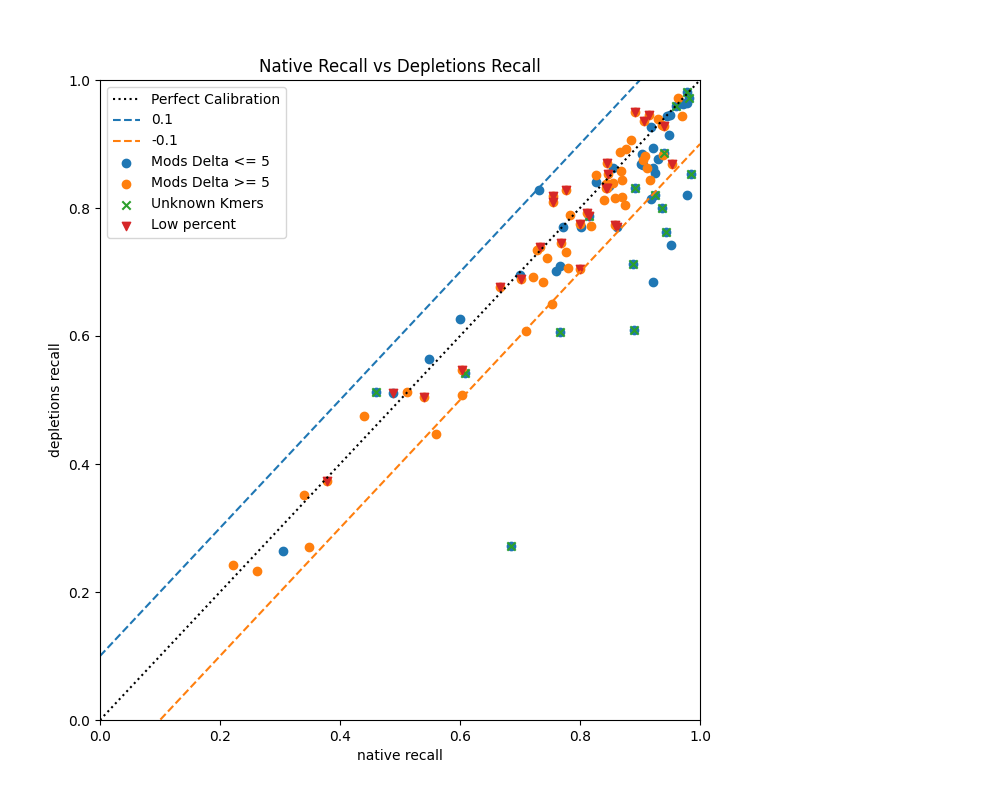

BIG DIFF:  RDN18-1 1006 8.0 95 False 0.10230000000000006
BIG DIFF:  RDN18-1 1190 4.0 100 True 0.1814
BIG DIFF:  RDN18-1 1289 10.0 93 False 0.11320000000000002
LOW ACC:  RDN25-1 897 10.0 94 False 0.3484
LOW ACC:  RDN25-1 1055 4.0 95 False 0.3045
LOW ACC:  RDN25-1 1141 9.0 95 False 0.3407
BIG DIFF:  RDN25-1 1436 12.0 95 False 0.10170000000000001
BIG DIFF:  RDN25-1 1448 1.0 95 False 0.2084999999999999
BIG DIFF:  RDN25-1 2255 2.0 95 True 0.4117
BIG DIFF:  RDN25-1 2257 2.0 95 True 0.137
BIG DIFF:  RDN25-1 2277 2.0 100 True 0.1602
LOW ACC:  RDN25-1 2287 7.0 100 False 0.4403
BIG DIFF:  RDN25-1 2339 3.0 100 True 0.17479999999999996
BIG DIFF:  RDN25-1 2348 2.0 100 True 0.2814
BIG DIFF:  RDN25-1 2350 2.0 100 False 0.10349999999999993
LOW ACC:  RDN25-1 2394 21.0 95 False 0.221
LOW ACC:  RDN25-1 2618 15.0 87 False 0.3786
LOW ACC:  RDN25-1 2790 2.0 86 False 0.4881
LOW ACC:  RDN25-1 2842 17.0 95 False 0.2622
LOW ACC:  RDN25-1 2869 5.0 95 True 0.4606
BIG DIFF:  RDN25-1 2920 1.0 95 False 0.15790000000

In [14]:
%matplotlib notebook

plt.figure(figsize=[10, 8])
panel1 = plt.axes([0.1, 0.1, .6, .8])
panel1.set_title('Native Recall vs Depletions Recall')
panel1.set_xlim(0)
panel1.set_ylim(0)

panel1.set_xlabel('native recall')
panel1.set_ylabel('depletions recall')
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    panel1.plot(x_vals, y_vals, '--', label=str(intercept))

panel1.plot([0, 1], [0, 1], "k:", label="Perfect Calibration")
abline(1, 0.1)
abline(1, -0.1)

# panel1.scatter(native_no_pm[native_no_pm["delta"] <= 5]["recall"], knockdown_no_pm[knockdown_no_pm["delta"] <= 5]["recall"], label="All other Mods. Delta <= 5")
# panel1.scatter(native_no_pm[native_no_pm["delta"] > 5]["recall"], knockdown_no_pm[knockdown_no_pm["delta"] > 5]["recall"], label="All other Mods. Delta >= 5")
# panel1.scatter(native_pm[native_pm["delta"] <= 5]["recall"], knockdown_pm[knockdown_pm["delta"] <= 5]["recall"], label="2'O and pseudoU Kmers. Delta <= 5")
# panel1.scatter(native_pm[native_pm["delta"] > 5]["recall"], knockdown_pm[knockdown_pm["delta"] > 5]["recall"], label="2'O and pseudoU Kmers. Delta >= 5")
panel1.scatter(native_acc_df[native_acc_df["delta"] <= 5]["recall"], knockdown_acc_df[knockdown_acc_df["delta"] <= 5]["recall"], label="Mods Delta <= 5")
panel1.scatter(native_acc_df[native_acc_df["delta"] > 5]["recall"], knockdown_acc_df[knockdown_acc_df["delta"] > 5]["recall"], label="Mods Delta >= 5")
panel1.scatter(native_acc_df[native_acc_df["in_unknown"] == True]["recall"], knockdown_acc_df[native_acc_df["in_unknown"] == True]["recall"], 
               label="Unknown Kmers", marker="x")
panel1.scatter(native_acc_df[native_acc_df["percent"] < 90]["recall"], knockdown_acc_df[native_acc_df["percent"] < 90]["recall"], 
               label="Low percent", marker="v")

for i, (x, y) in enumerate(zip(native_acc_df["recall"], knockdown_acc_df["recall"])):
    if np.abs(x - y) > .1:
        label = " ".join([str(x) for x in native_acc_df.iloc[i][["contig", "reference_index", "delta", "percent", "in_unknown"]]])
        print("BIG DIFF: ", label, np.abs(x - y))
    else:
        if x < 0.5:
            label = " ".join([str(x) for x in native_acc_df.iloc[i][["contig", "reference_index", "delta", "percent", "in_unknown"]]])
            print("LOW ACC: ", label, x)
#         plt.annotate(label, # this is the text
#                      (x,y), # this is the point to label
#                      textcoords="offset points", # how to position the text
#                      xytext=(0,10), # distance from text to points (x,y)
#                      ha='center') # horizontal alignment can be left, right or center

panel1.legend(loc="upper left")
plt.show()

<IPython.core.display.Javascript object>


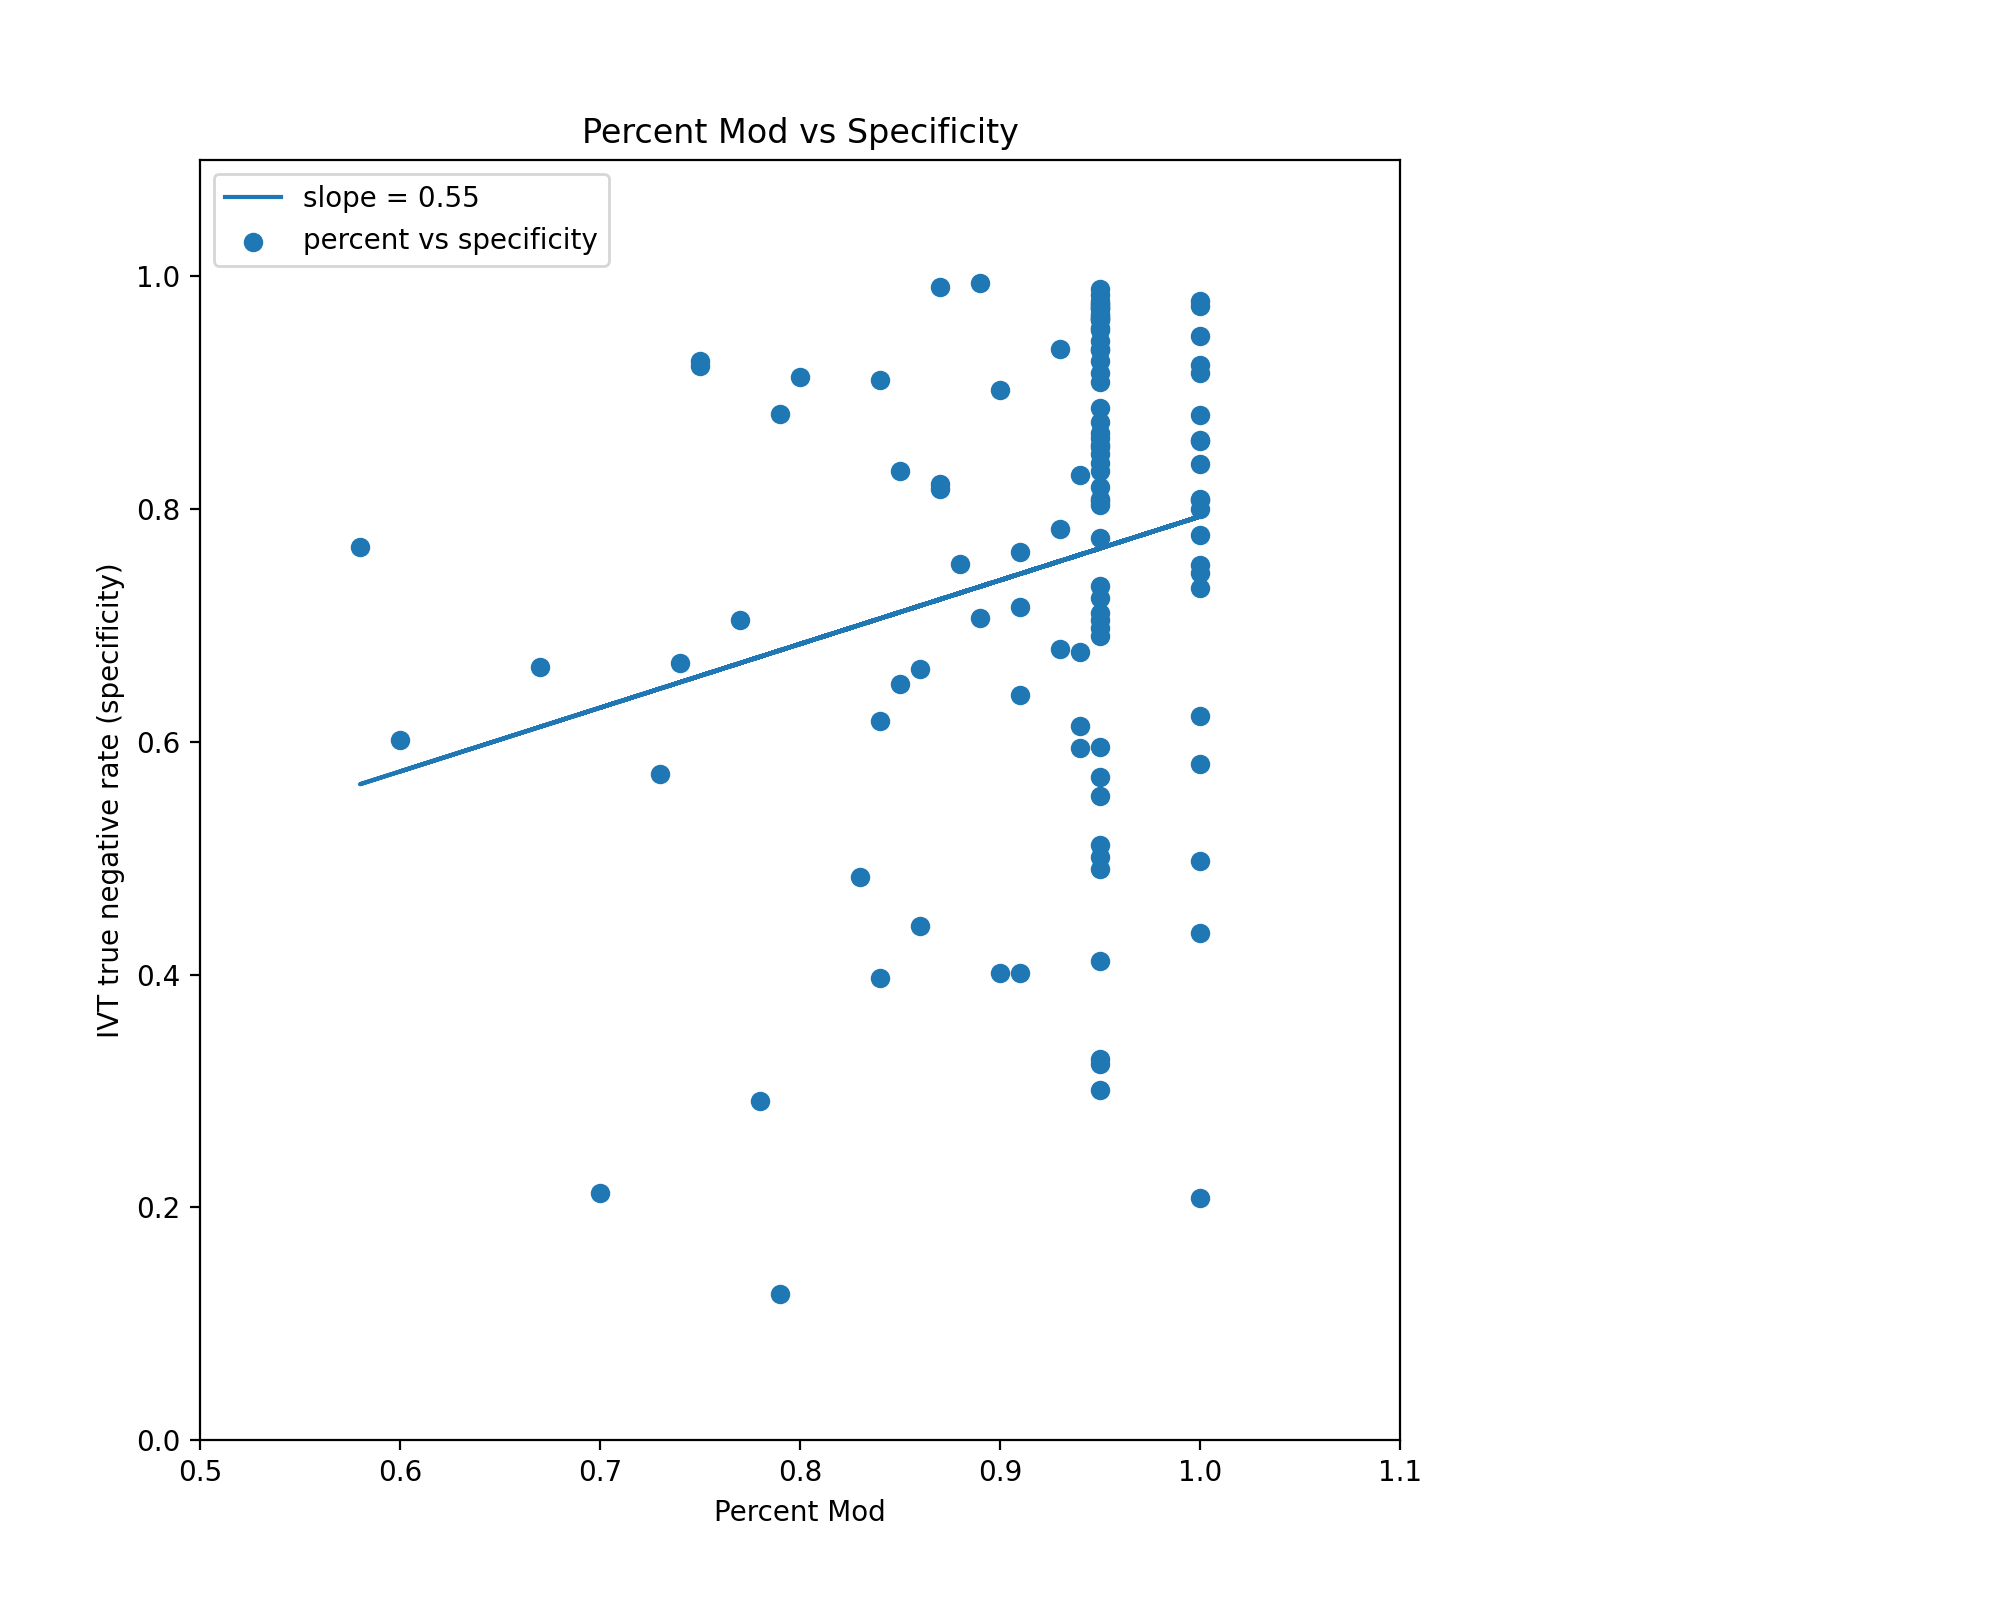

In [11]:
plt.figure(figsize=[10,8])
panel1 = plt.axes([0.1, 0.1, .6, .8])
panel1.set_title('Percent Mod vs Specificity')
panel1.set_xlim([0.5,1.1])
panel1.set_ylim([0,1.1])

panel1.set_xlabel('Percent Mod')
panel1.set_ylabel('IVT true negative rate (specificity)')
panel1.scatter(native_acc_df["percent"]/100, native_acc_df["specificity"], label="percent vs specificity")
m, b = np.polyfit(native_acc_df["percent"]/100, native_acc_df["specificity"], 1)
panel1.plot(native_acc_df["percent"]/100, m*np.array(native_acc_df["percent"]/100) + b, 
            label="slope = " + str(round(m, 2)))

panel1.legend(loc="upper left")
plt.show()

<IPython.core.display.Javascript object>


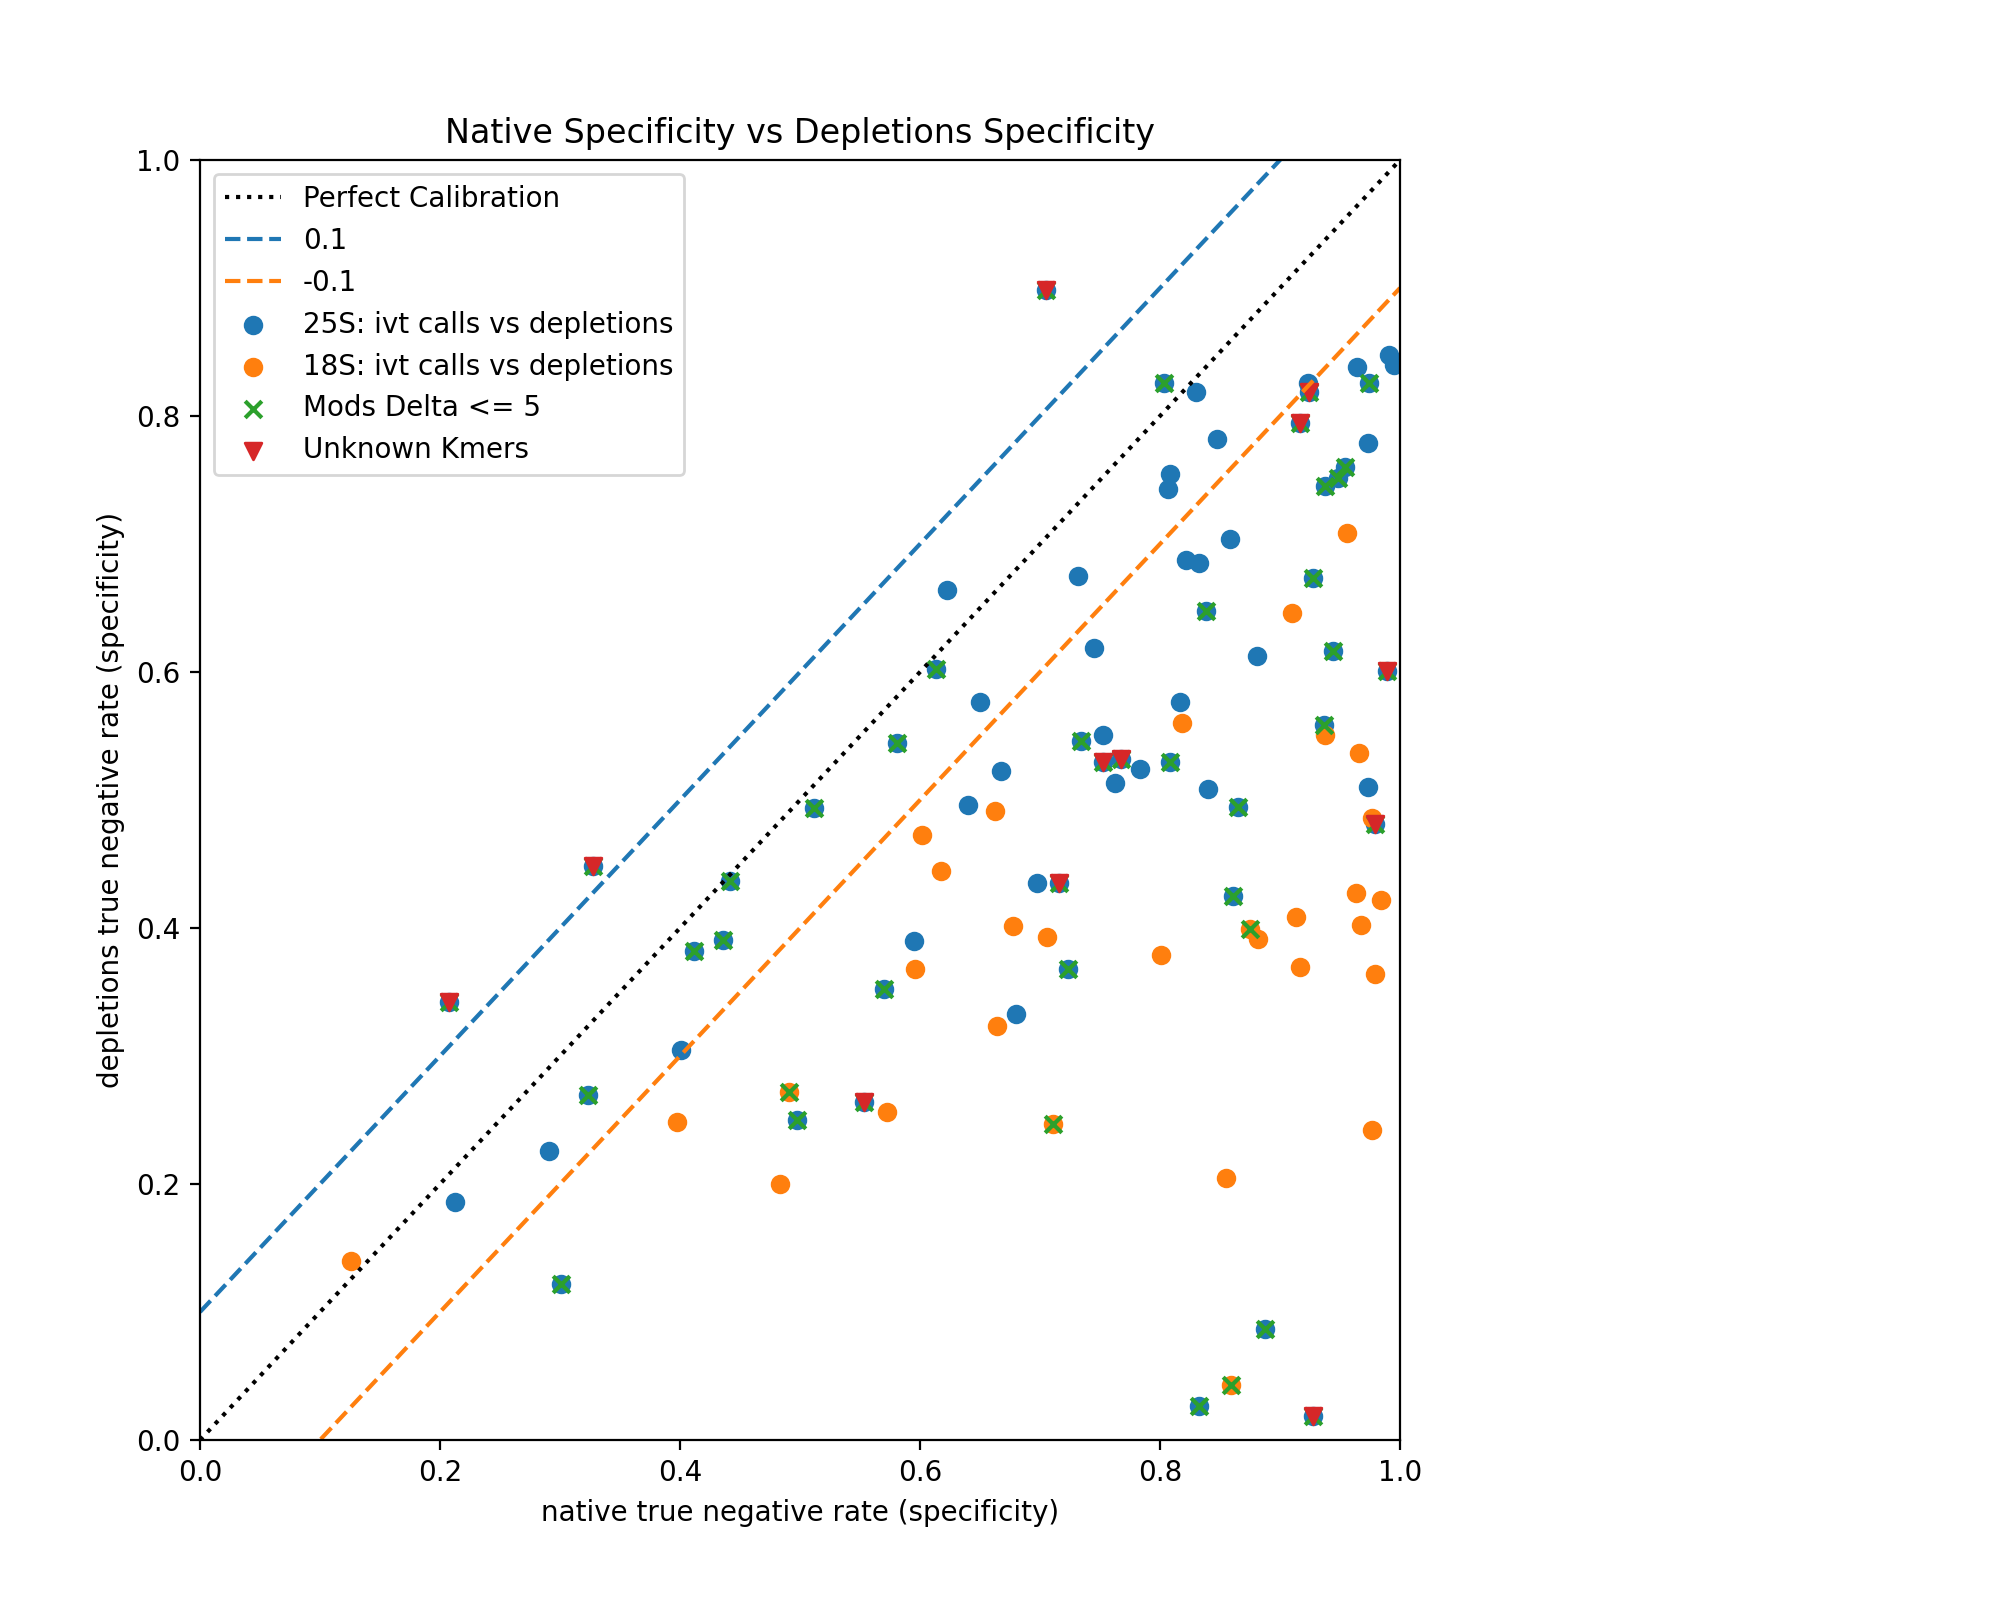

In [33]:
plt.figure(figsize=[10,8])
panel1 = plt.axes([0.1, 0.1, .6, .8])
panel1.set_title('Native Specificity vs Depletions Specificity')
panel1.set_xlim(0)
panel1.set_ylim(0)

panel1.set_xlabel('native true negative rate (specificity)')
panel1.set_ylabel('depletions true negative rate (specificity)')
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    panel1.plot(x_vals, y_vals, '--', label=str(intercept))

panel1.plot([0, 1], [0, 1], "k:", label="Perfect Calibration")
abline(1, 0.1)
abline(1, -0.1)
# panel1.scatter(native_acc_df[native_acc_df["percent"] >= 95]["specificity"], knockdown_acc_df[knockdown_acc_df["percent"] >= 95]["specificity"], label="Mods Delta <= 5")
# panel1.scatter(native_acc_df[native_acc_df["percent"] < 80]["specificity"], knockdown_acc_df[knockdown_acc_df["percent"] < 80]["specificity"], label="Mods Delta >= 5")
# panel1.scatter(native_acc_df[native_acc_df["contig"]=="RDN25-1"]["specificity"], knockdown_acc_df[knockdown_acc_df["contig"]=="RDN25-1"]["specificity"], label="25S: ivt calls vs depletions")
# panel1.scatter(native_acc_df[native_acc_df["contig"]=="RDN18-1"]["specificity"], knockdown_acc_df[knockdown_acc_df["contig"]=="RDN18-1"]["specificity"], label="18S: ivt calls vs depletions")
panel1.scatter(native_acc_df[native_acc_df["contig"]=="RDN25-1"]["specificity"], knockdown_acc_df[knockdown_acc_df["contig"]=="RDN25-1"]["specificity"], label="25S: ivt calls vs depletions")
panel1.scatter(native_acc_df[native_acc_df["contig"]=="RDN18-1"]["specificity"], knockdown_acc_df[knockdown_acc_df["contig"]=="RDN18-1"]["specificity"], label="18S: ivt calls vs depletions")
panel1.scatter(native_acc_df[native_acc_df["delta"] <= 5]["specificity"], knockdown_acc_df[knockdown_acc_df["delta"] <= 5]["specificity"], label="Mods Delta <= 5", marker='x')
panel1.scatter(native_acc_df[native_acc_df["in_unknown"] == True]["specificity"], knockdown_acc_df[native_acc_df["in_unknown"] == True]["specificity"], 
               label="Unknown Kmers", marker="v")

# panel1.scatter(native_pm["specificity"], knockdown_pm["specificity"], label="Modified Kmers")
panel1.legend()
plt.show()

In [29]:
native_acc_df[(native_acc_df["specificity"] - knockdown_acc_df["specificity"]) > .8]



,contig,reference_index,strand,variants,accuracy,precision,negative_predictive_value,recall,specificity,positive_likelihood_ratio,...,aucroc,avg_precision,brier_score,delta1,delta2,delta,in_2prime,in_pseudo,in_unknown,percent
31,RDN18-1,1571,+,Gc,0.9217,0.8950,0.9618,0.9723,0.8591,6.9033,...,0.9726,0.9712,0.0636,3.0,144.0,3.0,False,False,False,100
38,RDN25-1,648,+,Aa,0.9126,0.8518,0.9629,0.9499,0.8871,8.4164,...,0.9459,0.9167,0.1136,1.0,4.0,1.0,False,False,False,95
104,RDN25-1,2920,+,Td,0.8941,0.8110,0.9807,0.9777,0.8327,5.8422,...,0.9853,0.9874,0.0875,1.0,41.0,1.0,False,False,False,95
105,RDN25-1,2921,+,Gc,0.9521,0.9089,0.9888,0.9857,0.9274,13.5846,...,0.9925,0.9943,0.0787,1.0,1.0,1.0,False,True,True,95


In [30]:
knockdown_acc_df[(native_acc_df["specificity"] - knockdown_acc_df["specificity"]) > .8]


,contig,reference_index,strand,variants,accuracy,precision,negative_predictive_value,recall,specificity,positive_likelihood_ratio,...,aucroc,avg_precision,brier_score,delta1,delta2,delta,in_2prime,in_pseudo,in_unknown,percent
31,RDN18-1,1571,+,Gc,0.5608,0.5644,0.4741,0.9632,0.0427,1.0062,...,0.5132,0.5700,0.4279,3.0,144.0,3.0,False,False,False,100
38,RDN25-1,648,+,Aa,0.4817,0.4686,0.6497,0.9452,0.0866,1.0348,...,0.6438,0.5772,0.3925,1.0,4.0,1.0,False,False,False,95
104,RDN25-1,2920,+,Td,0.3888,0.4145,0.1487,0.8198,0.0265,0.8421,...,0.3115,0.3634,0.5692,1.0,41.0,1.0,False,False,False,95
105,RDN25-1,2921,+,Gc,0.3999,0.4223,0.1321,0.8531,0.0188,0.8694,...,0.3119,0.3642,0.5619,1.0,1.0,1.0,False,True,True,95
